In [ ]:
# Install needed dependencies onto Colab runtime
!pip install datasets
!pip install vaderSentiment
!pip install transformers
!pip install torch
!pip install contractions
!pip install vaderSentiment

In [2]:
# Import libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import re
from transformers import pipeline
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Mount drive to access and save files to local folders
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/351_Data'
os.listdir(folder_path)

Mounted at /content/drive


['train.csv', 'test.csv', 'raw_data', 'meta', 'processed']

# Data Preprocessing

## Converting json data to csv
- Filtered so only the necessary columns are downloaded

In [3]:
# Processes a JSONL.GZ file in chunks and writes only the needed fields to a CSV
# (Processing all at once would be much much slower)
def process_jsonl_in_chunks(filepath, output_path, fields_to_extract, chunk_size=10000, max_records=None):

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    chunk = []
    chunk_counter = 0
    line_num = 0

    # Remove the existing file if it exists
    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"Existing output file found and deleted: {output_path}")

    print(f"Starting processing: {filepath}")

    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for line in f:
            line_num += 1

            # Optional: Stop after reaching max_records
            if max_records is not None and line_num > max_records:
                print(f"Reached max_records limit of {max_records}. Stopping.")
                break

            try:
                json_obj = json.loads(line)

                # Extract only the selected fields
                filtered_obj = {field: json_obj.get(field, None) for field in fields_to_extract}

                chunk.append(filtered_obj)

                # Write the chunk to CSV if we hit the chunk size
                if len(chunk) >= chunk_size:
                    df_chunk = pd.DataFrame(chunk)

                    df_chunk.to_csv(
                        output_path,
                        mode='a',
                        index=False,
                        header=(chunk_counter == 0)
                    )

                    print(f"Saved chunk {chunk_counter} (lines up to {line_num})")

                    chunk = []
                    chunk_counter += 1

            except json.JSONDecodeError as e:
                print(f"JSON decoding error on line {line_num}: {e}")

    # Save any remaining records in the last chunk
    if chunk:
        df_chunk = pd.DataFrame(chunk)
        df_chunk.to_csv(
            output_path,
            mode='a',
            index=False,
            header=(chunk_counter == 0)
        )
        print(f"Saved final chunk {chunk_counter} (lines up to {line_num})")

    print(f"Finished processing. Output saved to: {output_path}")


In [7]:
# Chosen columns for meta data
meta_fields = [
    'parent_asin',
    'main_category',
    'categories',
    'title',
    'average_rating',
    'rating_number',  # Could take this out
    'price',
    'store'
]

# Paths for each meta file
meta_Pet_Supplies_path = '/content/drive/My Drive/351_Data/meta/meta_Pet_Supplies.jsonl.gz'
output_pet_meta_csv = '/content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv'

meta_Electronics_path = '/content/drive/My Drive/351_Data/meta/meta_Electronics.jsonl.gz'
output_electronics_meta_csv = '/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv'

meta_All_Beauty_path = '/content/drive/My Drive/351_Data/meta/meta_All_Beauty.jsonl.gz'
output_all_beauty_meta_csv = '/content/drive/My Drive/351_Data/processed/meta_All_Beauty_processed.csv'

meta_Home_and_Kitchen_path = '/content/drive/My Drive/351_Data/meta/meta_Home_and_Kitchen.jsonl.gz'
output_home_and_kitchen_meta_csv = '/content/drive/My Drive/351_Data/processed/meta_Home_and_Kitchen_processed.csv'

meta_Grocery_and_Gourmet_Food_path = '/content/drive/My Drive/351_Data/meta/meta_Grocery_and_Gourmet_Food.jsonl.gz'
output_grocery_and_gourmet_food_meta_csv = '/content/drive/My Drive/351_Data/processed/meta_Grocery_and_Gourmet_Food_processed.csv'

# Call chunk processing function for meta files
process_jsonl_in_chunks(
    filepath=meta_Pet_Supplies_path,
    output_path=output_pet_meta_csv,
    fields_to_extract=meta_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=meta_Electronics_path,
    output_path=output_electronics_meta_csv,
    fields_to_extract=meta_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=meta_All_Beauty_path,
    output_path=output_all_beauty_meta_csv,
    fields_to_extract=meta_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=meta_Home_and_Kitchen_path,
    output_path=output_home_and_kitchen_meta_csv,
    fields_to_extract=meta_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=meta_Grocery_and_Gourmet_Food_path,
    output_path=output_grocery_and_gourmet_food_meta_csv,
    fields_to_extract=meta_fields,
    chunk_size=10000,
    max_records=100000
)

# Chosen columns for reviews
data_fields = [
    'parent_asin',
    'title', # Title of review
    'text', # Main body of review
    'rating', # From 1-5
    'verified_purchase',
    'timestamp'
]

# Paths for each review file
raw_Pet_Supplies_path = '/content/drive/My Drive/351_Data/raw_data/Pet_Supplies.jsonl.gz'
output_Pet_Supplies_csv = '/content/drive/My Drive/351_Data/processed/Pet_Supplies_processed.csv'

raw_Electronics_path = '/content/drive/My Drive/351_Data/raw_data/Electronics.jsonl.gz'
output_Electronics_csv = '/content/drive/My Drive/351_Data/processed/Electronics_processed.csv'

raw_All_Beauty_path = '/content/drive/My Drive/351_Data/raw_data/All_Beauty.jsonl.gz'
output_All_Beauty_csv = '/content/drive/My Drive/351_Data/processed/All_Beauty_processed.csv'

raw_Home_and_Kitchen_path = '/content/drive/My Drive/351_Data/raw_data/Home_and_Kitchen.jsonl.gz'
output_Home_and_Kitchen_csv = '/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_processed.csv'

raw_Grocery_and_Gourmet_Food_path = '/content/drive/My Drive/351_Data/raw_data/Grocery_and_Gourmet_Food.jsonl.gz'
output_Grocery_and_Gourmet_Food_csv = '/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_processed.csv'

# Call chunk processing function for review files
process_jsonl_in_chunks(
    filepath=raw_Pet_Supplies_path,
    output_path=output_Pet_Supplies_csv,
    fields_to_extract=data_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=raw_Electronics_path,
    output_path=output_Electronics_csv,
    fields_to_extract=data_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=raw_All_Beauty_path,
    output_path=output_All_Beauty_csv,
    fields_to_extract=data_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=raw_Home_and_Kitchen_path,
    output_path=output_Home_and_Kitchen_csv,
    fields_to_extract=data_fields,
    chunk_size=10000,
    max_records=100000
)

process_jsonl_in_chunks(
    filepath=raw_Grocery_and_Gourmet_Food_path,
    output_path=output_Grocery_and_Gourmet_Food_csv,
    fields_to_extract=data_fields,
    chunk_size=10000,
    max_records=100000
)



Existing output file found and deleted: /content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv
Starting processing: /content/drive/My Drive/351_Data/meta/meta_Pet_Supplies.jsonl.gz
Saved chunk 0 (lines up to 10000)
Saved chunk 1 (lines up to 20000)
Saved chunk 2 (lines up to 30000)
Saved chunk 3 (lines up to 40000)
Saved chunk 4 (lines up to 50000)
Saved chunk 5 (lines up to 60000)
Saved chunk 6 (lines up to 70000)
Saved chunk 7 (lines up to 80000)
Saved chunk 8 (lines up to 90000)
Saved chunk 9 (lines up to 100000)
Reached max_records limit of 100000. Stopping.
Finished processing! Output saved to: /content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv
Existing output file found and deleted: /content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv
Starting processing: /content/drive/My Drive/351_Data/meta/meta_Electronics.jsonl.gz
Saved chunk 0 (lines up to 10000)
Saved chunk 1 (lines up to 20000)
Saved chunk 2 (lines up to 3000

## Merging metadata and review date files together for easier model training

In [29]:
# Pet Supplies
df_pet_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Pet_Supplies_processed.csv')
df_pet_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_processed.csv')

df_pet_merged = df_pet_reviews.merge(
    df_pet_meta[['parent_asin', 'price', 'main_category']],
    on='parent_asin',
    how='left'
)

df_pet_merged = df_pet_merged[df_pet_merged['verified_purchase'] == True]

print("Pet Supplies merged")
print(df_pet_merged.head())


# Electronics
df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')
df_elec_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Electronics_processed.csv')

df_elec_merged = df_elec_reviews.merge(
    df_elec_meta[['parent_asin', 'price', 'main_category']],
    on='parent_asin',
    how='left'
)

df_elec_merged = df_elec_merged[df_elec_merged['verified_purchase'] == True]

print("Electronics merged")
print(df_elec_merged.head())


# All Beauty
df_beauty_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_All_Beauty_processed.csv')
df_beauty_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_processed.csv')

df_beauty_merged = df_beauty_reviews.merge(
    df_beauty_meta[['parent_asin', 'price', 'main_category']],
    on='parent_asin',
    how='left'
)

df_beauty_merged = df_beauty_merged[df_beauty_merged['verified_purchase'] == True]

print("All Beauty merged")
print(df_beauty_merged.head())


# Home and Kitchen
df_home_kitchen_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Home_and_Kitchen_processed.csv')
df_home_kitchen_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_processed.csv')

df_home_kitchen_merged = df_home_kitchen_reviews.merge(
    df_home_kitchen_meta[['parent_asin', 'price', 'main_category']],
    on='parent_asin',
    how='left'
)

df_home_kitchen_merged = df_home_kitchen_merged[df_home_kitchen_merged['verified_purchase'] == True]

print("Home and Kitchen merged")
print(df_home_kitchen_merged.head())


# Grocery and Gourmet Food
df_grocery_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Grocery_and_Gourmet_Food_processed.csv')
df_grocery_reviews = pd.read_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_processed.csv')

df_grocery_merged = df_grocery_reviews.merge(
    df_grocery_meta[['parent_asin', 'price', 'main_category']],
    on='parent_asin',
    how='left'
)

df_grocery_merged = df_grocery_merged[df_grocery_merged['verified_purchase'] == True]

print("Grocery and Gourmet Food merged")
print(df_grocery_merged.head())


Pet Supplies merged!
  parent_asin                                              title  \
0  B0BHTBS5RM  Sticky stair riser tread thingies are utterly ...   
1  B0BJ16KKML  Dangerous bc metal not properly coated! Rough ...   
2  B0BX76YVP9                      Arrived damaged/dented/rusted   
3  B0BM6V2SH8                                My pups love these!   
4  B0986BSRB1                        My pups refuse to eat them.   

                                                text  rating  \
0  Tried to load photos, but none of my photos or...     4.0   
1  Where to begin?  I’ve been trying to get the 2...     1.0   
2  Unfortunately mine arrived damaged/dented whic...     3.0   
3  My pups love these!  It’s one of their favorit...     5.0   
4  Idk why, but my pups will not eat either flavo...     3.0   

   verified_purchase      timestamp  price main_category  
0               True  1675529329744  53.62  Pet Supplies  
1               True  1665513673369  48.99  Pet Supplies  
2       

<ipython-input-29-912d15bad0c7>:21: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_elec_meta = pd.read_csv('/content/drive/My Drive/351_Data/processed/meta_Electronics_processed.csv')


Electronics merged!
  parent_asin                                        title  \
0  B083NRGZMM            Smells like gasoline! Going back!   
1  B07N69T6TM      Didn’t work at all lenses loose/broken.   
2  B01G8JO5F2                                   Excellent!   
3  B001OC5JKY                       Great laptop backpack!   
4  B07CJYMRWM  Best Headphones in the Fifties price range!   

                                                text  rating  \
0  First & most offensive: they reek of gasoline ...     3.0   
1  These didn’t work. Idk if they were damaged in...     1.0   
2  I love these. They even come with a carry case...     5.0   
3  I was searching for a sturdy backpack for scho...     5.0   
4  I've bought these headphones three times becau...     5.0   

   verified_purchase      timestamp price main_category  
0               True  1658185117948   NaN           NaN  
1               True  1592678549731   NaN           NaN  
2               True  1523093017534   NaN       

## Label reviews as price related or not based on keywords

In [30]:
# Define price-related keywords
price_keywords = [
    'price', 'expensive', 'cheap', 'worth', 'cost', 'value for money',
    'overpriced', 'affordable', 'budget', 'deal', 'pricy', 'discount', 'sale',
    'bargain', 'quality', 'money', 'exorbitant', 'reasonable', 'premium'
]

# Compile regex pattern
price_pattern = re.compile(r'\b(' + '|'.join(price_keywords) + r')\b', re.IGNORECASE)

# Add a new column called 'price_related' which is True if the text contains a price-related keyword
def label_price_related_reviews(df, text_col='text'):
    df['price_related'] = df[text_col].apply(lambda x: bool(price_pattern.search(str(x))))
    return df

# Pet Supplies
df_pet_merged = label_price_related_reviews(df_pet_merged, text_col='text')
print("Price-related labels added for Pet Supplies!")
print(df_pet_merged[['text', 'price_related']].sample(5))

# Electronics
df_elec_merged = label_price_related_reviews(df_elec_merged, text_col='text')
print("Price-related labels added for Electronics!")
print(df_elec_merged[['text', 'price_related']].sample(5))

# All Beauty
df_beauty_merged = label_price_related_reviews(df_beauty_merged, text_col='text')
print("Price-related labels added for All Beauty!")
print(df_beauty_merged[['text', 'price_related']].sample(5))

# Home and Kitchen
df_home_kitchen_merged = label_price_related_reviews(df_home_kitchen_merged, text_col='text')
print("Price-related labels added for Home and Kitchen!")
print(df_home_kitchen_merged[['text', 'price_related']].sample(5))

# Grocery and Gourmet Food
df_grocery_merged = label_price_related_reviews(df_grocery_merged, text_col='text')
print("Price-related labels added for Grocery and Gourmet Food!")
print(df_grocery_merged[['text', 'price_related']].sample(5))


Price-related labels added for Pet Supplies!
                                                    text  price_related
79390  Very easy to assemble.  Sturdy.  My cat won't ...          False
48723                                       Good quality           True
58721              Worked good but dog didn't like them.          False
23584  We LOVE Petstages toys. Well, I should say the...          False
36288  Not sure why, but the venison with fish didn't...          False
Price-related labels added for Electronics!
                                                    text  price_related
91492  Additionally it seems bulky and heavy. Not “sl...          False
50120  I like the clock radios that have a projector ...          False
53355  These are great! I'd never used them before --...          False
68431  Arrived on time. Works perfectly. Adds tons of...          False
23951  I thought this would be perfect as an extra po...          False
Price-related labels added for All Beauty!
    

# BERT

## Instantiate DistilBERT model

In [32]:
# Load sentiment analysis pipeline and push to CUDA (device=0)
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0)


# Function to analyze sentiment
# Adds two new columns: 'sentiment_label' and 'sentiment_score'.
# text_col: Name of the column containing the review text
def analyze_sentiment_in_batches(df, text_col='text', batch_size=32):

    sentiment_labels = []
    sentiment_scores = []

    # Convert column to list
    texts = df[text_col].astype(str).tolist()

    # Loop through batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
        batch = texts[i:i+batch_size]

        # Truncate reviews to a maximum of 512 tokens before processing to reduce computation strain
        truncated_batch = [text[:512] for text in batch]

        # Get batch of predictions
        results = sentiment_pipeline(truncated_batch)

        # Append results
        for result in results:
            sentiment_labels.append(result['label'])
            sentiment_scores.append(result['score'])

    # Add results back to the dataframe
    df['sentiment_label'] = sentiment_labels
    df['sentiment_score'] = sentiment_scores

    return df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


## Actual prediction happens here
- Will take around 30 minutes to run for 100k records using A100 High-Ram GPU

In [45]:
# Pet Products

# Grab 100000 rows of each catagory
df_pet_sample = df_pet_merged.head(100000).copy()

# Run sentiment analysis
df_pet_sentiment_sample = analyze_sentiment_in_batches(df_pet_sample, text_col='text', batch_size=32)

# Preview the output
print("Pet Supplies sentiment analysis complete")
print(df_pet_sentiment_sample[['text', 'rating', 'sentiment_label', 'sentiment_score']].sample(10))

# Save to CSV
df_pet_sentiment_sample.to_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_BERT_sentiment_sample.csv', index=False)


# Electronics
df_elec_sample = df_elec_merged.head(100000).copy()
df_elec_sentiment_sample = analyze_sentiment_in_batches(df_elec_sample, text_col='text', batch_size=32)
print("Electronics sentiment analysis complete")
print(df_elec_sentiment_sample[['text', 'rating', 'sentiment_label', 'sentiment_score']].sample(10))
df_elec_sentiment_sample.to_csv('/content/drive/My Drive/351_Data/processed/Electronics_BERT_sentiment_sample.csv', index=False)


# All Beauty Products
df_beauty_sample = df_beauty_merged.head(100000).copy()
df_beauty_sentiment_sample = analyze_sentiment_in_batches(df_beauty_sample, text_col='text', batch_size=32)
print("All Beauty sentiment analysis complete")
print(df_beauty_sentiment_sample[['text', 'rating', 'sentiment_label', 'sentiment_score']].sample(10))
df_beauty_sentiment_sample.to_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_BERT_sentiment_sample.csv', index=False)


# Home and Kitchen
df_home_kitchen_sample = df_home_kitchen_merged.head(100000).copy()
df_home_kitchen_sentiment_sample = analyze_sentiment_in_batches(df_home_kitchen_sample, text_col='text', batch_size=32)
print("Home and Kitchen sentiment analysis complete")
print(df_home_kitchen_sentiment_sample[['text', 'rating', 'sentiment_label', 'sentiment_score']].sample(10))
df_home_kitchen_sentiment_sample.to_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_BERT_sentiment_sample.csv', index=False)

# Grocery and Gourmet Food
df_grocery_sample = df_grocery_merged.head(100000).copy()
df_grocery_sentiment_sample = analyze_sentiment_in_batches(df_grocery_sample, text_col='text', batch_size=32)
print("Grocery and Gourmet Food sentiment analysis complete!")
print(df_grocery_sentiment_sample[['text', 'rating', 'sentiment_label', 'sentiment_score']].sample(10))
df_grocery_sentiment_sample.to_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_BERT_sentiment_sample.csv', index=False)


Processing Batches:   0%|          | 1/2525 [00:00<41:37,  1.01it/s]


KeyboardInterrupt: 

## Load the dataframe without re-labelling (Assuming you have the labels entries already)

In [ ]:
#Pet Supplies
df_pet_sample = df_pet_merged.head(100000).copy()
df_pet_sentiment_sample = pd.read_csv(f"{folder_path}/processed/Pet_Supplies_BERT_sentiment_sample.csv")
print("Loaded Pet Supplies sentiment data")


#### Electronics
df_elec_sample = df_elec_merged.head(100000).copy()
df_elec_sentiment_sample = pd.read_csv(f"{folder_path}/processed/Electronics_BERT_sentiment_sample.csv")
print("Loaded Electronics sentiment data")


# All Beauty
df_beauty_sample = df_beauty_merged.head(100000).copy()
df_beauty_sentiment_sample = pd.read_csv(f"{folder_path}/processed/All_Beauty_BERT_sentiment_sample.csv")
print("Loaded All Beauty sentiment data")


# Home and Kitchen
df_home_kitchen_sample = df_home_kitchen_merged.head(100000).copy()
df_home_kitchen_sentiment_sample = pd.read_csv(f"{folder_path}/processed/Home_and_Kitchen_BERT_sentiment_sample.csv")
print("Loaded Home and Kitchen sentiment data")


# Grocery and Gourmet Food
df_grocery_sample = df_grocery_merged.head(100000).copy()
df_grocery_sentiment_sample = pd.read_csv(f"{folder_path}/processed/Grocery_and_Gourmet_Food_BERT_sentiment_sample.csv")
print("Loaded Grocery sentiment data")


## Group dataframes together for cross-category plots

In [5]:
# Add a column for the category name in each DataFrame
df_pet_sentiment_sample['category'] = 'Pet Supplies'
df_elec_sentiment_sample['category'] = 'Electronics'
df_beauty_sentiment_sample['category'] = 'All Beauty'
df_home_kitchen_sentiment_sample['category'] = 'Home and Kitchen'
df_grocery_sentiment_sample['category'] = 'Grocery and Gourmet Food'

# Combine all categories into one DataFrame
df_all_sentiment = pd.concat([
    df_pet_sentiment_sample,
    df_elec_sentiment_sample,
    df_beauty_sentiment_sample,
    df_home_kitchen_sentiment_sample,
    df_grocery_sentiment_sample
], ignore_index=True)

print("Combined sentiment DataFrame shape:", df_all_sentiment.shape)
print(df_all_sentiment['category'].value_counts())


Combined sentiment DataFrame shape: (397022, 12)
category
All Beauty                  87784
Pet Supplies                80790
Electronics                 78983
Grocery and Gourmet Food    78613
Home and Kitchen            70852
Name: count, dtype: int64


## Bar chart showing positive vs negative sentiment proportions by category

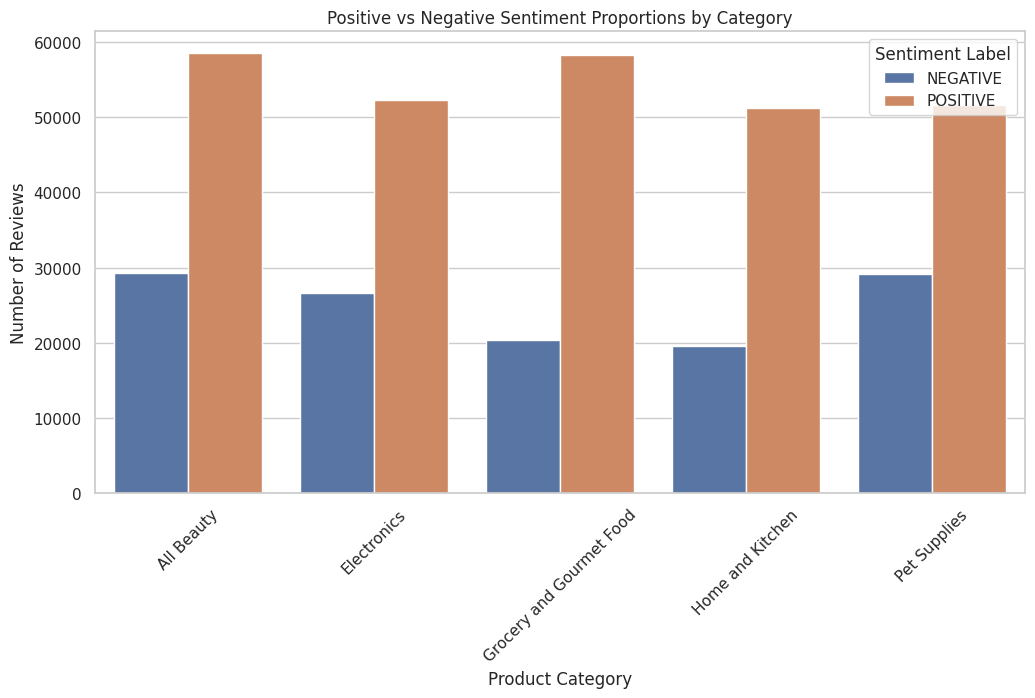

In [47]:
# Group by category and sentiment label to count occurrences
sentiment_counts = df_all_sentiment.groupby(['category', 'sentiment_label']).size().reset_index(name='count')

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_counts, x='category', y='count', hue='sentiment_label')
plt.title('Positive vs Negative Sentiment Proportions by Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Label')
plt.show()

## Overall pos/neg proportions

In [48]:

# ======================================
# Pet Supplies - Price Related Sentiment
# ======================================
df_pet_price_related = df_pet_sentiment_sample[df_pet_sentiment_sample['price_related'] == True]

pet_sentiment_counts = df_pet_price_related['sentiment_label'].value_counts(normalize=True) * 100
print("Pet Supplies - Price-Related Sentiment Proportions (%):")
print(pet_sentiment_counts)
print("="*50)


# ======================================
# Electronics - Price Related Sentiment
# ======================================
df_elec_price_related = df_elec_sentiment_sample[df_elec_sentiment_sample['price_related'] == True]

elec_sentiment_counts = df_elec_price_related['sentiment_label'].value_counts(normalize=True) * 100
print("Electronics - Price-Related Sentiment Proportions (%):")
print(elec_sentiment_counts)
print("="*50)


# ======================================
# All Beauty - Price Related Sentiment
# ======================================
df_beauty_price_related = df_beauty_sentiment_sample[df_beauty_sentiment_sample['price_related'] == True]

beauty_sentiment_counts = df_beauty_price_related['sentiment_label'].value_counts(normalize=True) * 100
print("All Beauty - Price-Related Sentiment Proportions (%):")
print(beauty_sentiment_counts)
print("="*50)


# ======================================
# Home and Kitchen - Price Related Sentiment
# ======================================
df_home_kitchen_price_related = df_home_kitchen_sentiment_sample[df_home_kitchen_sentiment_sample['price_related'] == True]

home_kitchen_sentiment_counts = df_home_kitchen_price_related['sentiment_label'].value_counts(normalize=True) * 100
print("Home and Kitchen - Price-Related Sentiment Proportions (%):")
print(home_kitchen_sentiment_counts)
print("="*50)


# ======================================
# Grocery and Gourmet Food - Price Related Sentiment
# ======================================
df_grocery_price_related = df_grocery_sentiment_sample[df_grocery_sentiment_sample['price_related'] == True]

grocery_sentiment_counts = df_grocery_price_related['sentiment_label'].value_counts(normalize=True) * 100
print("Grocery and Gourmet Food - Price-Related Sentiment Proportions (%):")
print(grocery_sentiment_counts)
print("="*50)


Pet Supplies - Price-Related Sentiment Proportions (%):
sentiment_label
POSITIVE    60.525475
NEGATIVE    39.474525
Name: proportion, dtype: float64
Electronics - Price-Related Sentiment Proportions (%):
sentiment_label
POSITIVE    64.782609
NEGATIVE    35.217391
Name: proportion, dtype: float64
All Beauty - Price-Related Sentiment Proportions (%):
sentiment_label
POSITIVE    62.432716
NEGATIVE    37.567284
Name: proportion, dtype: float64
Home and Kitchen - Price-Related Sentiment Proportions (%):
sentiment_label
POSITIVE    68.301461
NEGATIVE    31.698539
Name: proportion, dtype: float64
Grocery and Gourmet Food - Price-Related Sentiment Proportions (%):
sentiment_label
POSITIVE    69.767612
NEGATIVE    30.232388
Name: proportion, dtype: float64


## Hypothesis Test
- Kruskal Wallis since we are comparing across 3+ catagories

In [ ]:
# Kruskal Wallis test

from scipy.stats import kruskal

# Prepare data: split sentiment scores by category
grouped_scores = [
    df_all_sentiment[df_all_sentiment['category'] == category]['sentiment_score'].dropna().tolist()
    for category in df_all_sentiment['category'].unique()
]

# Run the Kruskal-Wallis H-test
stat, p_value = kruskal(*grouped_scores)

# Output results
print(f"Kruskal-Wallis H-test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in sentiment scores across categories")
else:
    print("No statistically significant difference in sentiment scores across categories")


## Polarity score of price related reviews across catagories
- A positive polarity score means # of positive reviews > # of negative reviews

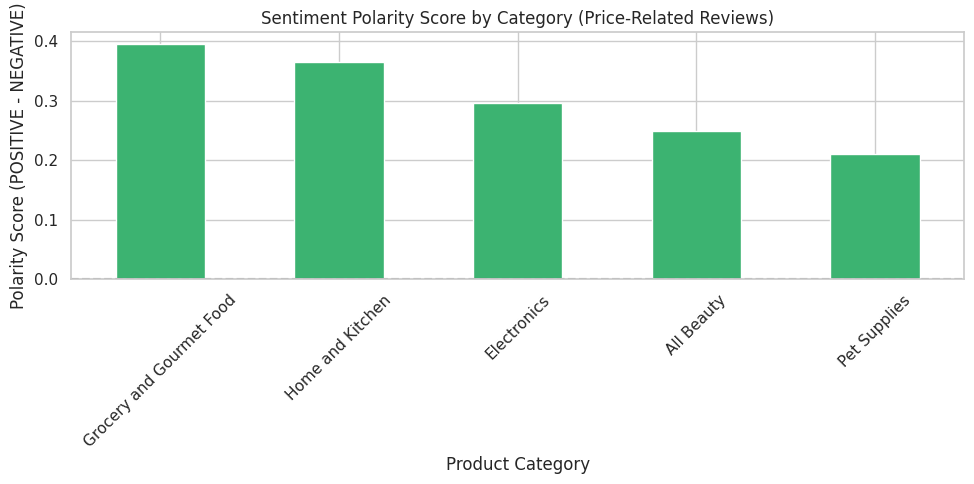

In [52]:
# Filter to price-related reviews only
df_price_related = df_all_sentiment[df_all_sentiment['price_related'] == True]

# Count sentiment labels per category
sentiment_counts = df_price_related.groupby(['category', 'sentiment_label']).size().unstack(fill_value=0)

# Normalize proportions
sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Calc polarity score
sentiment_props['polarity_score'] = sentiment_props['POSITIVE'] - sentiment_props['NEGATIVE']

# Sort in descending order
sentiment_props = sentiment_props.sort_values('polarity_score', ascending=False)

plt.figure(figsize=(10, 5))
sentiment_props['polarity_score'].plot(kind='bar', color='mediumseagreen')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Sentiment Polarity Score by Category (Price-Related Reviews)')
plt.ylabel('Polarity Score (POSITIVE - NEGATIVE)')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# VADER

## Instantiate VADER model

In [34]:
# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment scoring
def analyze_sentiment_vader(df, text_col='text'):
    sentiment_labels = []
    sentiment_scores = []

    texts = df[text_col].astype(str).tolist()

    for text in tqdm(texts, desc="VADER Sentiment Analysis"):
        score = vader_analyzer.polarity_scores(text)
        sentiment_scores.append(score['compound'])

        # Apply basic thresholds used in VADER documentation
        if score['compound'] >= 0.05:
            sentiment_labels.append("POSITIVE")
        elif score['compound'] <= -0.05:
            sentiment_labels.append("NEGATIVE")
        else:
            sentiment_labels.append("NEUTRAL")

    # Add results back to DataFrame
    df['vader_sentiment_label'] = sentiment_labels
    df['vader_sentiment_score'] = sentiment_scores
    return df


## Actual predictions happen here
- Much faster than BERT, should only take a minute or two

In [35]:
df_pet_sentiment_vader = analyze_sentiment_vader(df_pet_sample.copy(), text_col='text')
df_pet_sentiment_vader.to_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_VADER_sentiment_sample.csv', index=False)
df_beauty_sentiment_vader = analyze_sentiment_vader(df_beauty_sample.copy(), text_col='text')
df_beauty_sentiment_vader.to_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_VADER_sentiment_sample.csv', index=False)
df_elec_sentiment_vader = analyze_sentiment_vader(df_elec_sample.copy(), text_col='text')
df_elec_sentiment_vader.to_csv('/content/drive/My Drive/351_Data/processed/Electronics_VADER_sentiment_sample.csv', index=False)
df_home_kitchen_sentiment_vader = analyze_sentiment_vader(df_home_kitchen_sample.copy(), text_col='text')
df_home_kitchen_sentiment_vader.to_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_VADER_sentiment_sample.csv', index=False)
df_grocery_sentiment_vader = analyze_sentiment_vader(df_grocery_sample.copy(), text_col='text')
df_grocery_sentiment_vader.to_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_VADER_sentiment_sample.csv', index=False)


VADER Sentiment Analysis: 100%|██████████| 78613/78613 [00:14<00:00, 5292.71it/s]


# Comparing BERT vs VADER
- Plotting classificaiton confidence scores
- Bar chart number of matching labels between BERT and VADER

In [ ]:
# Merge each category’s BERT and VADER sentiment outputs
df_pet_bv = pd.merge(
    df_pet_sentiment_sample[['parent_asin', 'timestamp', 'text', 'sentiment_label', 'sentiment_score']],
    df_pet_sentiment_vader[['parent_asin', 'timestamp', 'vader_sentiment_label', 'vader_sentiment_score']],
    on=['parent_asin', 'timestamp'],
    how='inner'
)

df_elec_bv = pd.merge(
    df_elec_sentiment_sample[['parent_asin', 'timestamp', 'text', 'sentiment_label', 'sentiment_score']],
    df_elec_sentiment_vader[['parent_asin', 'timestamp', 'vader_sentiment_label', 'vader_sentiment_score']],
    on=['parent_asin', 'timestamp'],
    how='inner'
)

df_beauty_bv = pd.merge(
    df_beauty_sentiment_sample[['parent_asin', 'timestamp', 'text', 'sentiment_label', 'sentiment_score']],
    df_beauty_sentiment_vader[['parent_asin', 'timestamp', 'vader_sentiment_label', 'vader_sentiment_score']],
    on=['parent_asin', 'timestamp'],
    how='inner'
)

df_home_bv = pd.merge(
    df_home_kitchen_sentiment_sample[['parent_asin', 'timestamp', 'text', 'sentiment_label', 'sentiment_score']],
    df_home_kitchen_sentiment_vader[['parent_asin', 'timestamp', 'vader_sentiment_label', 'vader_sentiment_score']],
    on=['parent_asin', 'timestamp'],
    how='inner'
)

df_grocery_bv = pd.merge(
    df_grocery_sentiment_sample[['parent_asin', 'timestamp', 'text', 'sentiment_label', 'sentiment_score']],
    df_grocery_sentiment_vader[['parent_asin', 'timestamp', 'vader_sentiment_label', 'vader_sentiment_score']],
    on=['parent_asin', 'timestamp'],
    how='inner'
)


# Save combined CSV
df_pet_bv.to_csv('/content/drive/My Drive/351_Data/processed/Pet_Supplies_BERT_VADER_combined.csv', index=False)
df_elec_bv.to_csv('/content/drive/My Drive/351_Data/processed/Electronics_BERT_VADER_combined.csv', index=False)
df_beauty_bv.to_csv('/content/drive/My Drive/351_Data/processed/All_Beauty_BERT_VADER_combined.csv', index=False)
df_home_bv.to_csv('/content/drive/My Drive/351_Data/processed/Home_and_Kitchen_BERT_VADER_combined.csv', index=False)
df_grocery_bv.to_csv('/content/drive/My Drive/351_Data/processed/Grocery_and_Gourmet_Food_BERT_VADER_combined.csv', index=False)


# Dictionary of merged dataframes and their labels
merged_dfs = {
    "Pet Supplies": df_pet_bv,
    "Electronics": df_elec_bv,
    "All Beauty": df_beauty_bv,
    "Home and Kitchen": df_home_bv,
    "Grocery and Gourmet Food": df_grocery_bv
}


sns.set(style="whitegrid")

# Loop through and plot each category
for category_name, df in merged_dfs.items():
    # KDE Plot of sentiment score distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['sentiment_score'], label='BERT Score', fill=True, color='tab:blue')
    sns.kdeplot(df['vader_sentiment_score'], label='VADER Score', fill=True, color='tab:orange')
    plt.title(f"Sentiment Score Distribution — {category_name}")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # BERT vs VADER sentiment label match vs mismatch bar chart
    matches = (df['sentiment_label'] == df['vader_sentiment_label'])
    match_counts = matches.value_counts().rename({True: 'Match', False: 'Mismatch'})

    # Ensure both labels exist
    match_counts = match_counts.reindex(['Match', 'Mismatch'], fill_value=0)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=match_counts.index, y=match_counts.values, palette=['green', 'red'])
    plt.title(f"Sentiment Label Agreement — {category_name}")
    plt.ylabel("Number of Reviews")
    plt.xlabel("Label Agreement")
    plt.tight_layout()
    plt.show()




In [9]:
conf_matrix = pd.crosstab(df_all_sentiment['category'], df_all_sentiment['sentiment_label'])

print(conf_matrix)

df_price_related_all = df_all_sentiment[df_all_sentiment['price_related'] == True]

conf_matrix_price_related = pd.crosstab(df_price_related_all['category'], df_price_related_all['sentiment_label'])

print(conf_matrix_price_related)


sentiment_label           NEGATIVE  POSITIVE
category                                    
All Beauty                   29310     58474
Electronics                  26685     52298
Grocery and Gourmet Food     20365     58248
Home and Kitchen             19647     51205
Pet Supplies                 29135     51655
sentiment_label           NEGATIVE  POSITIVE
category                                    
All Beauty                    5723      9511
Electronics                   6966     12814
Grocery and Gourmet Food      4124      9517
Home and Kitchen              4492      9679
Pet Supplies                  4943      7579


# LDA

In [49]:
# Make dictionary of pain point categories
# -----------------------
pain_point_categories = {
    "product_quality": [
        "broken", "defective", "cheap", "poor", "damaged", "does not work"
    ],
    "customer_service": [
        "rude", "unhelpful", "no response", "ignored", "bad service",
        "never replied", "unprofessional", "no help", "unavailable", "unresponsive"
    ],
    "shipping": [
        "late", "delayed", "missing", "did not arrive", "wrong item",
        "lost package", "delivered to wrong address", "no tracking", "delayed shipment"
    ],
    "pricing": [
        "expensive", "overpriced", "not worth", "waste of money",
        "ripoff", "exorbitant"
    ],
    "usability": [
        "confusing", "complicated", "not intuitive", "hard to use",
        "instructions unclear", "difficult to operate", "setup was hard",
        "interface confusing"
    ],
    "expectation_mismatch": [
        "not as described", "false advertising", "misleading",
        "did not match", "than expected", "different from description",
        "not what i expected", "not the same as pictured"
    ]
}

pain_point_vocabulary = sorted(set(
    phrase.lower()
    for phrases in pain_point_categories.values()
    for phrase in phrases
))


# Preprocess text
def expand_and_clean(text):
    text = contractions.fix(str(text))
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

def contains_pain_point(text):
    lower = str(text).lower()
    return any(p in lower for p in pain_point_vocabulary)

def categorize_term(term):
    for cat, phrases in pain_point_categories.items():
        if any(p in term for p in phrases):
            return cat
    return "uncategorized"

extra_stopwords = {
    'like','as','it','and','they','just','get','got','use','one','really',
    'the','this','that','its','is','was','are','were','you','your','dont',
    'thing','stuff','item','everything','nothing','very','quite'
}
stopwords = ENGLISH_STOP_WORDS.union(extra_stopwords)


category_term_weights_across_products = {}


# Display and store LDA Output
def display_topics_binned(model, feature_names, category_name, no_top_words=10):
    category_weights = Counter()

    for topic in model.components_:
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        for idx in top_indices:
            word = feature_names[idx]
            weight = topic[idx]
            bin_ = categorize_term(word)
            category_weights[bin_] += weight
            print(f"{word} ({bin_})", end=" + ")
        print()

    print("\nWeighted Pain‑Point Summary:")
    for b, w in category_weights.items():
        print(f"{b}: {w:.2f}")

    category_term_weights_across_products[category_name] = dict(category_weights)


def lda_pain_points(df_category, category_name, sentiment_filter='NEGATIVE', no_topics=1, no_top_words=10):
    print(f"\n\nPain Point Topics for {category_name} [{sentiment_filter}]")

    df_filtered = df_category.copy()

    # Sentiment filter for BERT
    if sentiment_filter in ['NEGATIVE', 'POSITIVE']:
        df_filtered = df_filtered[df_filtered['sentiment_label'] == sentiment_filter]

    # Apply pain point filter
    df_filtered = df_filtered[df_filtered['text'].apply(contains_pain_point)]

    if df_filtered.empty:
        print("No matching reviews found.")
        return

    df_filtered['clean_text'] = df_filtered['text'].apply(expand_and_clean)

    # Vectorization
    vectorizer = TfidfVectorizer(
        stop_words=list(stopwords),
        ngram_range=(1, 3),
        max_df=0.95,
        min_df=10,
        lowercase=True,
        vocabulary=pain_point_vocabulary
    )
    dtm = vectorizer.fit_transform(df_filtered['clean_text'])

    if dtm.shape[1] == 0:
        print("Vectorizer produced empty matrix.")
        return

    # Run LDA
    lda_model = LatentDirichletAllocation(n_components=no_topics, random_state=42)
    lda_model.fit(dtm)

    display_topics_binned(
        lda_model,
        vectorizer.get_feature_names_out(),
        category_name,
        no_top_words=no_top_words
    )

# Plot summary
def plot_pain_point_summary(weight_normalize=False):
    if not category_term_weights_across_products:
        print("Run lda_pain_points first.")
        return

    categories = list(category_term_weights_across_products.keys())
    pain_bins = list(pain_point_categories.keys())

    data = {b: [] for b in pain_bins}
    for cat in categories:
        weights = category_term_weights_across_products.get(cat, {})
        total = sum(weights.values()) or 1.0
        for b in pain_bins:
            val = weights.get(b, 0.0)
            data[b].append(val / total if weight_normalize else val)

    x = np.arange(len(categories))
    bar_width = 0.15
    plt.figure(figsize=(12, 6))

    for idx, (b, vals) in enumerate(data.items()):
        plt.bar(x + idx * bar_width, vals, bar_width,
                label=b.replace('_', ' ').title())

    plt.xticks(x + bar_width * len(pain_bins) / 2, categories, rotation=45)
    ylabel = "Weighted Sum (normalized)" if weight_normalize else "Weighted Sum"
    plt.ylabel(ylabel)
    plt.title("Weighted Pain‑Point Importance Across Product Categories")
    plt.legend(title="Pain‑Point Category")
    plt.tight_layout()
    plt.show()




Pain Point Topics for Pet Supplies [NEGATIVE]
expensive (pricing) + cheap (product_quality) + broken (product_quality) + poor (product_quality) + missing (shipping) + damaged (product_quality) + defective (product_quality) + late (shipping) + overpriced (pricing) + ignored (customer_service) + 

Weighted Pain‑Point Summary:
pricing: 756.01
product_quality: 1387.14
shipping: 251.37
customer_service: 63.80


Pain Point Topics for Electronics [NEGATIVE]
cheap (product_quality) + expensive (pricing) + poor (product_quality) + broken (product_quality) + defective (product_quality) + missing (shipping) + damaged (product_quality) + late (shipping) + complicated (usability) + overpriced (pricing) + 

Weighted Pain‑Point Summary:
product_quality: 2148.32
pricing: 603.39
shipping: 350.95
usability: 78.43


Pain Point Topics for All Beauty [NEGATIVE]
cheap (product_quality) + expensive (pricing) + broken (product_quality) + poor (product_quality) + missing (shipping) + damaged (product_quality

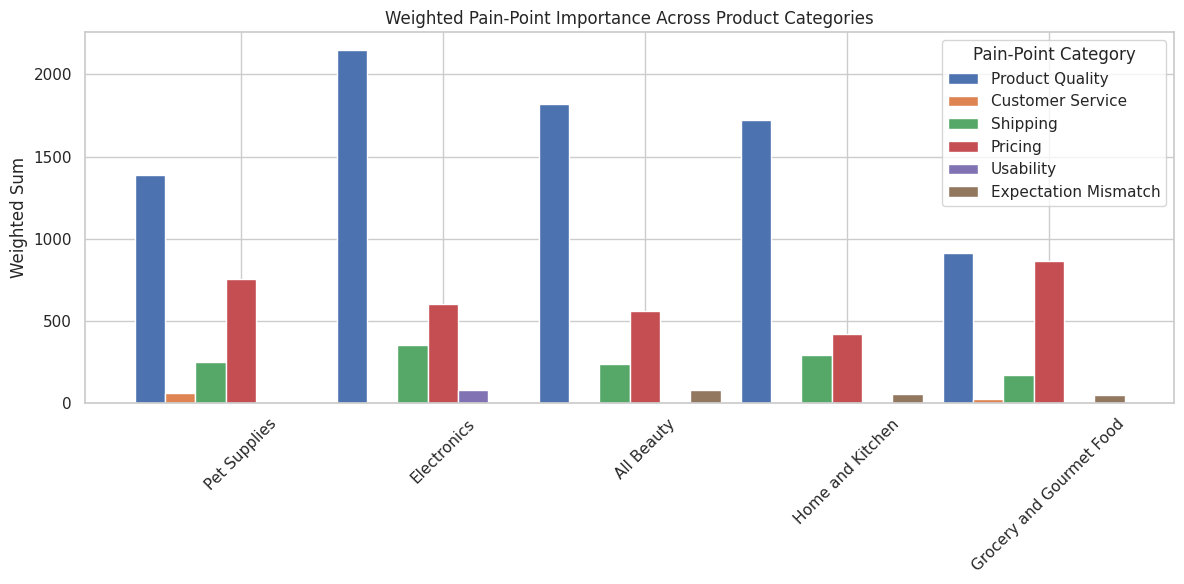

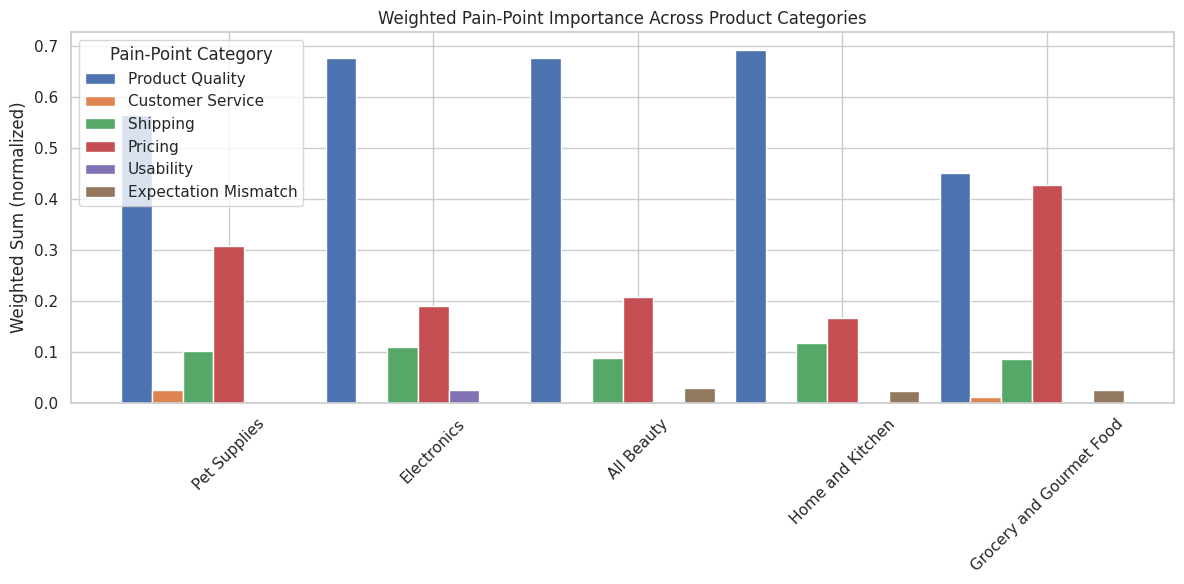

In [50]:
lda_pain_points(df_pet_sentiment_sample, "Pet Supplies", sentiment_filter='NEGATIVE')
lda_pain_points(df_elec_sentiment_sample, "Electronics", sentiment_filter='NEGATIVE')
lda_pain_points(df_beauty_sentiment_sample, "All Beauty", sentiment_filter='NEGATIVE')
lda_pain_points(df_home_kitchen_sentiment_sample, "Home and Kitchen", sentiment_filter='NEGATIVE')
lda_pain_points(df_grocery_sentiment_sample, "Grocery and Gourmet Food", sentiment_filter='NEGATIVE')

plot_pain_point_summary(weight_normalize=False)  # raw weights
plot_pain_point_summary(weight_normalize=True)   # normalized weights

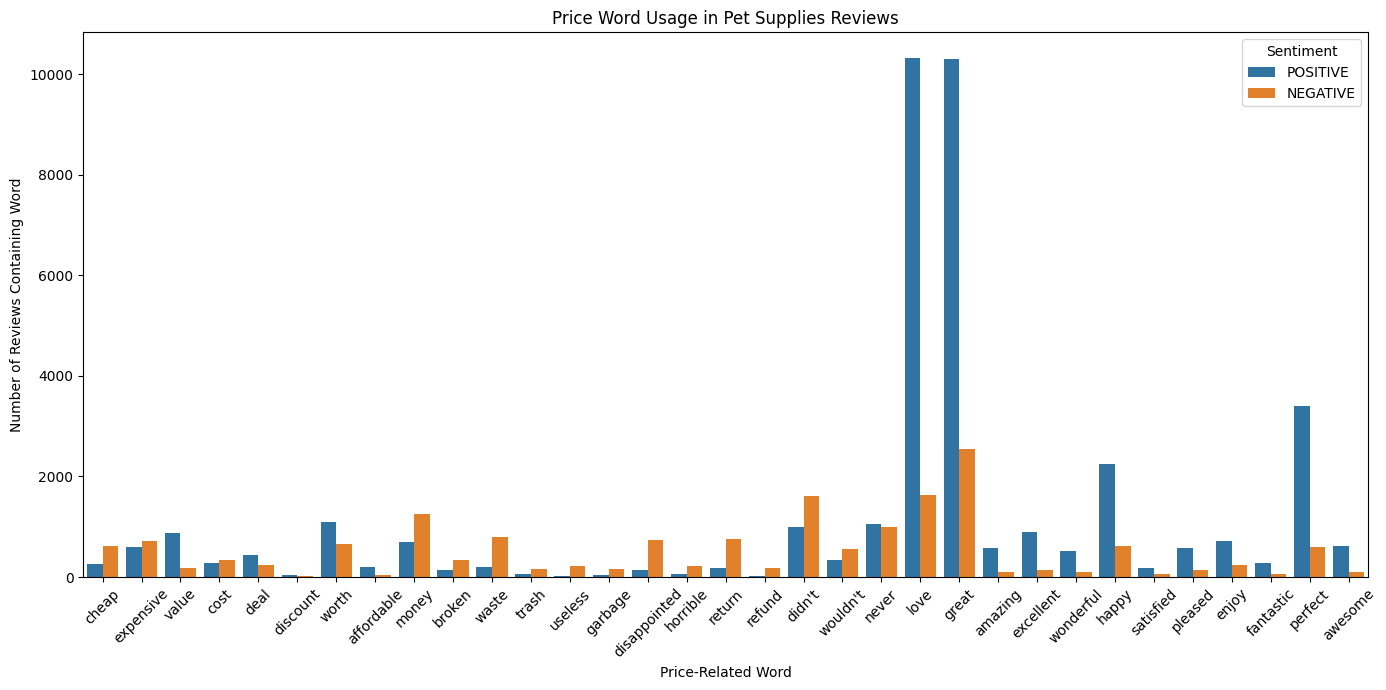

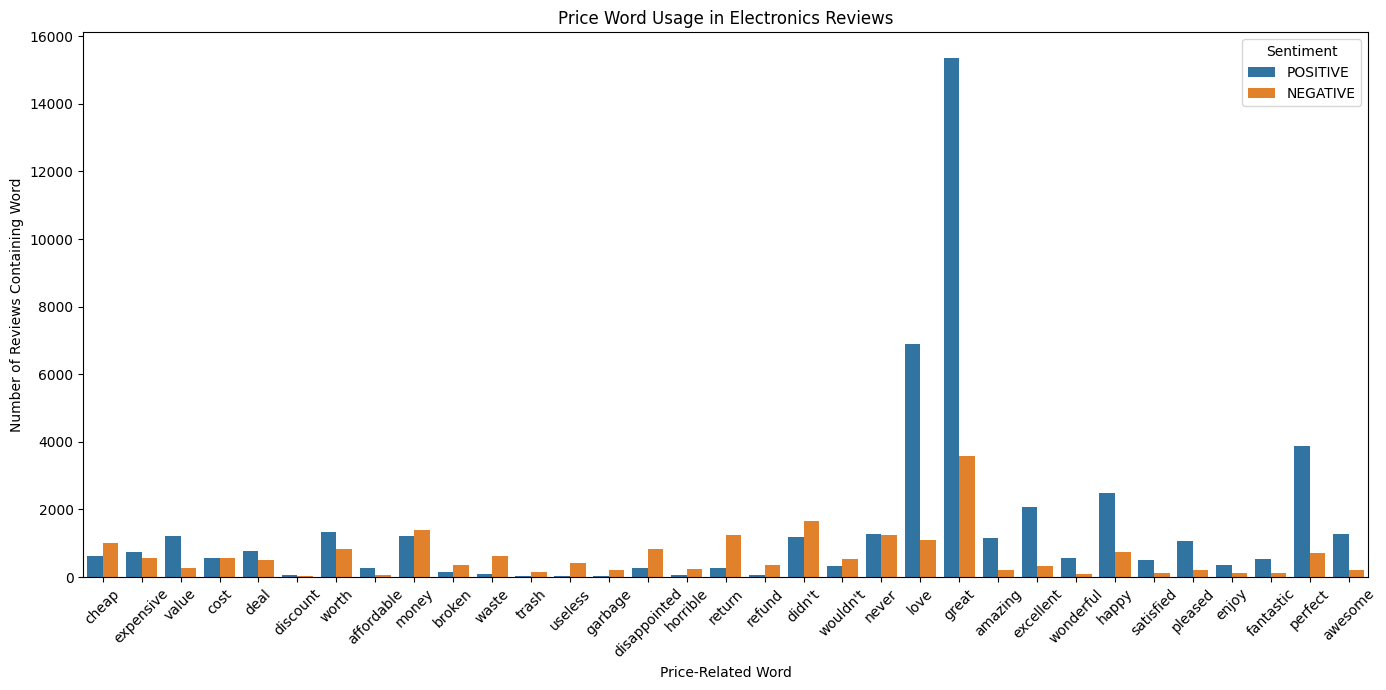

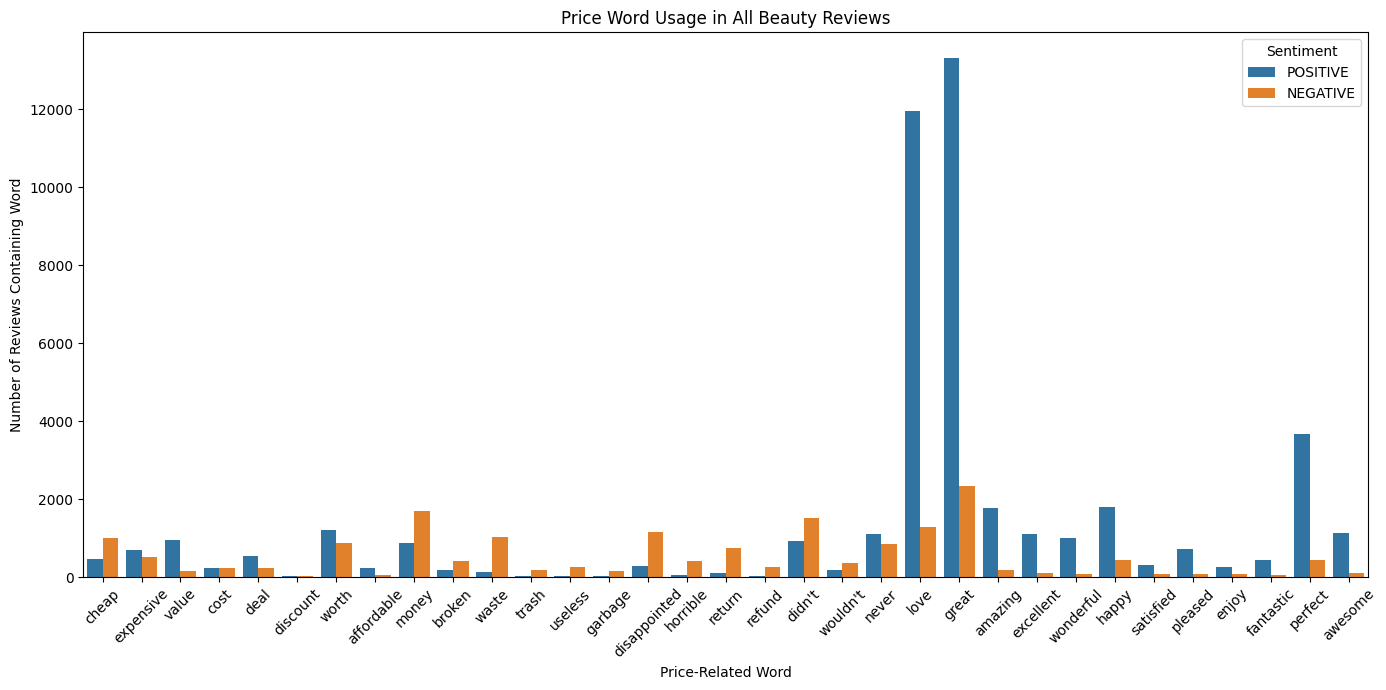

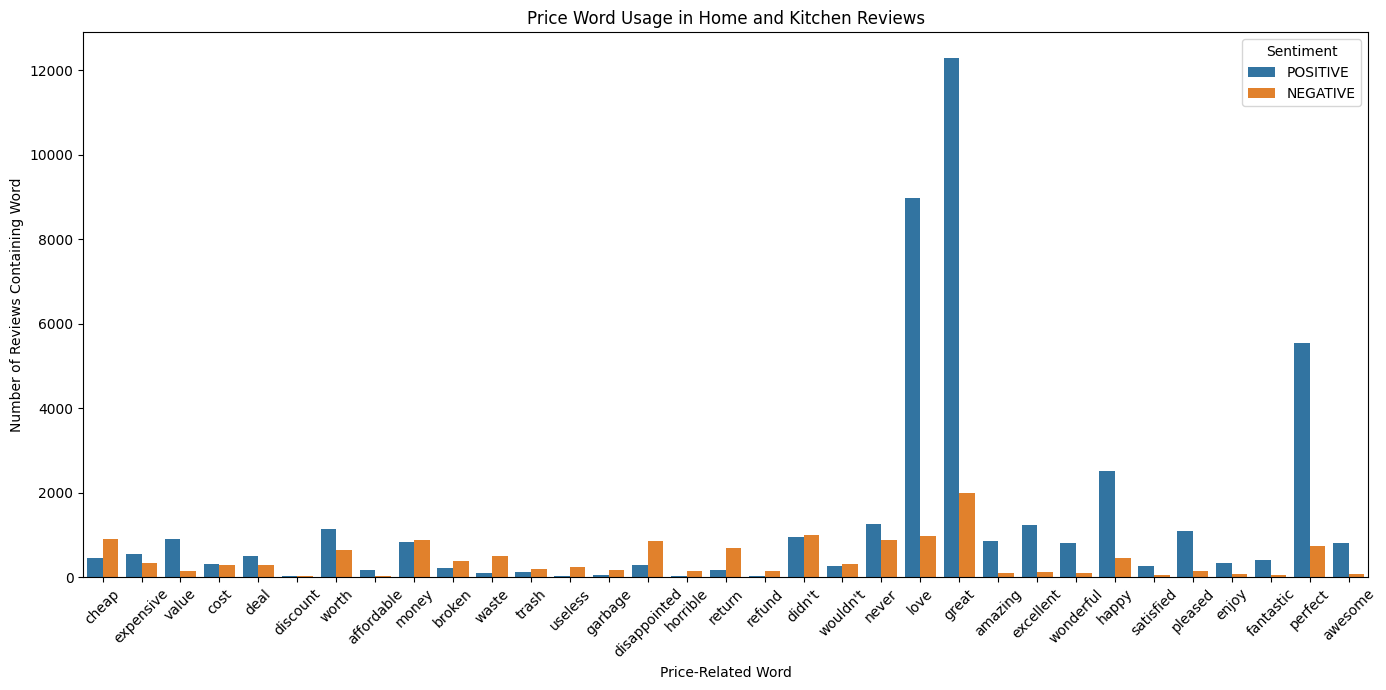

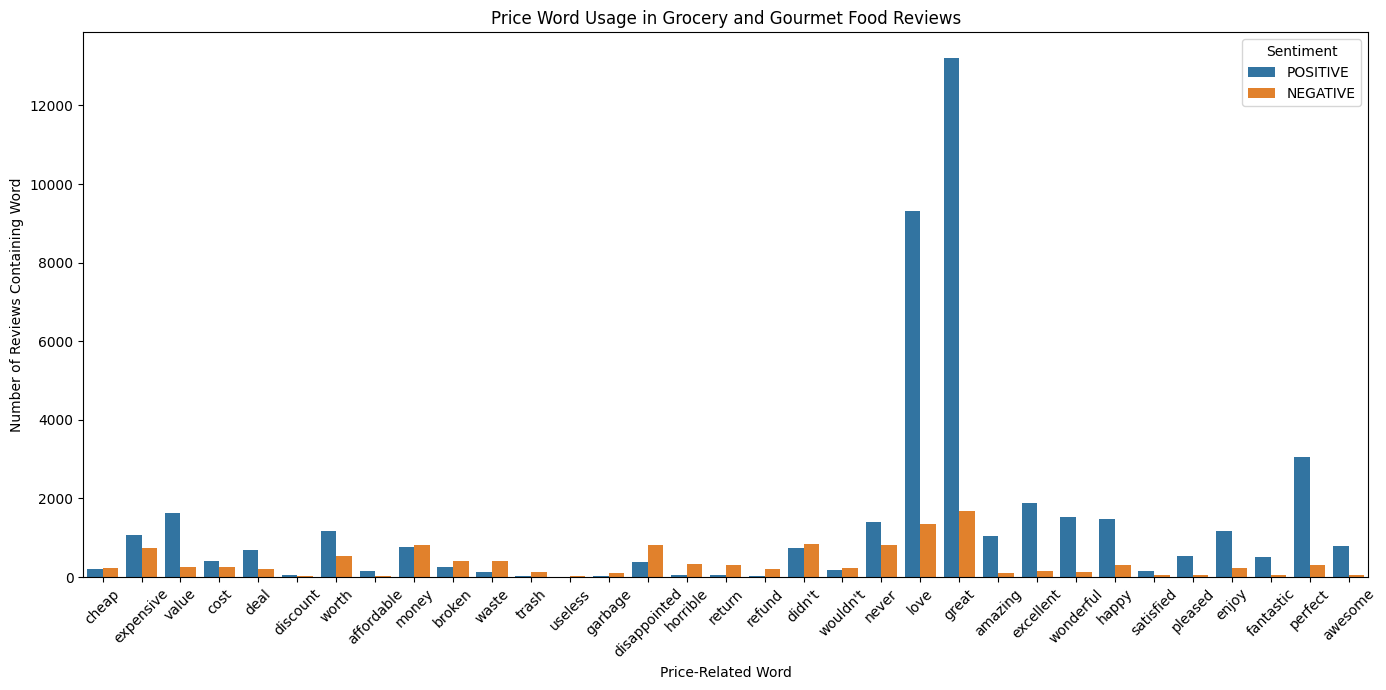

In [ ]:
categories = df_all_sentiment['category'].unique()

price_words = [
    "cheap", "expensive", "value", "cost", "deal", "discount",
    "worth", "affordable", "money"
]

anger_words = [
    "broken", "waste", "trash", "useless", "garbage",
    "cheap", "disappointed", "horrible", "return", "refund",
    "didn't", "wouldn't", "never"
]

joy_words = [
    "love", "great", "amazing", "excellent", "wonderful",
    "happy", "satisfied", "pleased", "enjoy", "fantastic",
    "perfect", "awesome"
]


# Function to count word occurrence
def count_word_occurrences(df, word):
    pattern = re.compile(rf"\b{re.escape(word)}\b", flags=re.IGNORECASE)
    return df['text'].apply(lambda x: bool(pattern.search(str(x))))

# Build chart data per category
category_charts = []

# for category in categories:
#     df_cat = df_all_sentiment[df_all_sentiment['category'] == category].copy()

#     for word in price_words:
#         df_cat['word_found'] = count_word_occurrences(df_cat, word)

#         for sentiment in ["POSITIVE", "NEGATIVE"]:
#             count = df_cat[(df_cat['sentiment_label'] == sentiment) & (df_cat['word_found'])].shape[0]
#             category_charts.append({
#                 "category": category,
#                 "word": word,
#                 "sentiment": sentiment,
#                 "count": count
#             })

# Price words
for category in categories:
    df_cat = df_all_sentiment[df_all_sentiment['category'] == category].copy()

    for word in price_words:
        df_cat['word_found'] = count_word_occurrences(df_cat, word)

        for sentiment in ["POSITIVE", "NEGATIVE"]:
            count = df_cat[(df_cat['sentiment_label'] == sentiment) & (df_cat['word_found'])].shape[0]
            category_charts.append({
                "category": category,
                "word": word,
                "sentiment": sentiment,
                "set": "price",
                "count": count
            })

# Angry words
for category in categories:
    df_cat = df_all_sentiment[df_all_sentiment['category'] == category].copy()

    for word in anger_words:
        df_cat['word_found'] = count_word_occurrences(df_cat, word)

        for sentiment in ["POSITIVE", "NEGATIVE"]:
            count = df_cat[(df_cat['sentiment_label'] == sentiment) & (df_cat['word_found'])].shape[0]
            category_charts.append({
                "category": category,
                "word": word,
                "sentiment": sentiment,
                "set": "anger",
                "count": count
            })

# Joyful words
for category in categories:
    df_cat = df_all_sentiment[df_all_sentiment['category'] == category].copy()

    for word in joy_words:
        df_cat['word_found'] = count_word_occurrences(df_cat, word)

        for sentiment in ["POSITIVE", "NEGATIVE"]:
            count = df_cat[(df_cat['sentiment_label'] == sentiment) & (df_cat['word_found'])].shape[0]
            category_charts.append({
                "category": category,
                "word": word,
                "sentiment": sentiment,
                "set": "joy",
                "count": count
            })

# Create dataframe for visualization
df_category_chart = pd.DataFrame(category_charts)

# plot one chart per category
for category in categories:
    plt.figure(figsize=(14, 7))
    data = df_category_chart[df_category_chart['category'] == category]
    sns.barplot(data=data, x="word", y="count", hue="sentiment")
    plt.title(f"Price Word Usage in {category} Reviews")
    plt.xlabel("Price-Related Word")
    plt.ylabel("Number of Reviews Containing Word")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()
